In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomialP

In [2]:
from keras.datasets import mnist

2024-04-14 15:37:42.480516: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 15:37:42.505724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 15:37:42.926482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# load data and count pixels

In [3]:
# load data
(train_img, train_lab), (test_img, test_lab) = mnist.load_data()

In [4]:
train_img.shape

(60000, 28, 28)

In [5]:
test_img.shape

(10000, 28, 28)

In [6]:
data_vec = train_img.reshape(60000, 784, 1)
data_vec = data_vec.reshape(60000, 784)
data_vec[data_vec>1]=1

# Adding a column of ones for the intercept
data_vec_intercept = sm.add_constant(data_vec)

In [7]:
test_vec = test_img.reshape(10000, 784, 1)
test_vec = test_vec.reshape(10000, 784)
test_vec[test_vec>1]=1

In [8]:
# sum the number of 1 as label

data_label = np.sum(data_vec == 0, axis = 1)
test_label = np.sum(test_vec == 0, axis = 1)

In [9]:
y_mean = np.mean(data_label)
y_var = np.var(data_label)
print(y_mean)
print(y_var)

634.0974
1718.6850132400002


In [10]:
def model_train(X, y):
    """
    training model using Negative Binomial model
    """
    y_var = np.var(y)
    y_mean = np.mean(y)
    alpha = (y_var-y_mean)/(y_mean **2)
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha))
    results = model.fit()
    print(results.summary())

    return results

In [11]:
model = model_train(data_vec_intercept,data_label)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59287
Model Family:        NegativeBinomial   Df Model:                          712
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7858e+05
Date:                Sun, 03 Mar 2024   Deviance:                       85.098
Time:                        20:01:27   Pearson chi2:                     84.8
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6346
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6894      0.002   4289.392      0.0

In [12]:
test_vec_intercept = sm.add_constant(test_vec)
pred_label = model.predict(test_vec_intercept)
# pred_label = np.rint(pred_label)

In [13]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(pred_label, test_label)
print(error)

2.380731125070424


# Taditional data spliting

In [14]:
from sklearn.model_selection import train_test_split

X_train0, X_train1, y_train0, y_train1 = train_test_split(data_vec, data_label, test_size = 0.3, random_state=42)

In [15]:
mean0 = np.mean(y_train0)
var0 = np.var(y_train0)
print('mean of training set 0: ', mean0)
print('variance of training set 0: ', var0)

mean1 = np.mean(y_train1)
var1 = np.var(y_train1)
print('mean of training set 1: ', mean1)
print('variance of training set 1: ', var1)

mean of training set 0:  634.0941190476191
variance of training set 0:  1712.664451128685
mean of training set 1:  634.1050555555555
variance of training set 1:  1732.7329077746913


In [16]:
X_train0_intercept = sm.add_constant(X_train0)
traditional0 = model_train(X_train0_intercept ,y_train0)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                42000
Model:                            GLM   Df Residuals:                    41296
Model Family:        NegativeBinomial   Df Model:                          703
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9494e+05
Date:                Sun, 03 Mar 2024   Deviance:                       58.644
Time:                        20:03:28   Pearson chi2:                     58.5
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6346
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6894      0.002   3584.116      0.0

In [17]:
X_train1_intercept = sm.add_constant(X_train1)
traditional1  = model_train(X_train1_intercept ,y_train1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18000
Model:                            GLM   Df Residuals:                    17319
Model Family:        NegativeBinomial   Df Model:                          680
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83648.
Date:                Sun, 03 Mar 2024   Deviance:                       25.407
Time:                        20:04:25   Pearson chi2:                     25.3
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6348
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6894      0.003   2311.281      0.0

In [18]:
print('test on traditional splitting model 0')
pred0 = traditional0.predict(test_vec_intercept)
# pred0 = np.rint(pred0)
mse0 = mean_squared_error(test_label, pred0)
print(mse0)

print('test on traditional splitting model 1')
pred1 = traditional1.predict(test_vec_intercept)
# pred1 = np.rint(pred1)
mse1 = mean_squared_error(test_label, pred1)
print(mse1)

test on traditional splitting model 0
2.3873039505157854
test on traditional splitting model 1
2.4644289235120094


# Poisson

$Y_{ijk} \sim \mbox{Poisson}(\pi_k \mu_{ij} t_{ij})$ where $\pi_1 + \pi_2 = 1$   
$Y_{ij+} = Y_{ij1} + Y_{ij2}$ defines the unobserved $Y_{ij1}$ and $Y_{ij2}$ as convolutionally thinned data   
$(Y_{ij1}, Y_{ij2}) ~|~  Y_{ij+} \sim \mbox{Multinomial}\{ y_{ij+}, (\pi_1, \pi_2) \}$. 

In [19]:
def poisson_thin(data, epsilon):
    if np.any(data < 0):
        print("Possion data must be non-negative")
        return
    if np.any(data != np.floor(data)):
        print("Possion data must be integer valued")
        return
    
#     Thinning
    thinned_data = np.array([np.random.multinomial(x, epsilon) for x in data])
    return thinned_data

In [20]:
eps = np.array([0.7, 0.3])

pois_thin = poisson_thin(data_label, eps)

In [21]:
pois_thin

array([[424, 194],
       [415, 193],
       [478, 186],
       ...,
       [469, 179],
       [450, 189],
       [436, 205]])

In [22]:
pois_thin0 =pois_thin[:,0]
pois_thin1 = pois_thin[:,1]

In [23]:
mean_pois=[np.mean(pois_thin0), np.mean(pois_thin1)]
print('Poisson thinning mean: ', mean_pois)

var_pois = [np.var(pois_thin0), np.var(pois_thin1)]
print('Poisson thinning variance: ', var_pois)

a = [y_mean*0.7, y_mean*0.3]
print('Dataset mean: ', a)

Poisson thinning mean:  [443.95008333333334, 190.14731666666665]
Poisson thinning variance:  [977.7398249930557, 288.09258113305555]
Dataset mean:  [443.86818, 190.22922]


In [24]:
# verify sum

import operator
sum_pois = list(map(operator.add, pois_thin0, pois_thin1))
equal_check = np.allclose(data_label, sum_pois)
print(equal_check)

True


In [25]:
model_pois0 = model_train(data_vec_intercept ,pois_thin0)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59287
Model Family:        NegativeBinomial   Df Model:                          712
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6572e+05
Date:                Sun, 03 Mar 2024   Deviance:                       8214.5
Time:                        20:07:25   Pearson chi2:                 8.21e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5810
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3331      0.002   3768.995      0.0

In [26]:
model_pois1 = model_train(data_vec_intercept ,pois_thin1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59287
Model Family:        NegativeBinomial   Df Model:                          712
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3877e+05
Date:                Sun, 03 Mar 2024   Deviance:                       27678.
Time:                        20:10:57   Pearson chi2:                 2.76e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.4191
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4842      0.002   2574.935      0.0

In [27]:
pois_pred0 = model_pois0.predict(test_vec_intercept)
pois_pred1 = model_pois1.predict(test_vec_intercept)

pois_pred = pois_pred0 + pois_pred1
# pois_pred = np.rint(pois_pred)

pois_mse = mean_squared_error(test_label, pois_pred)
print('test on poisson thinning model:', pois_mse)

test on poisson thinning model: 2.3766438319390426


# Binomial

In [28]:
from scipy.stats import multivariate_hypergeom

In [102]:
def binomthin(data, epsilon, pop):
    if np.min(data) < 0:
        print("Binomial data must be non-negative.")
        return
    
    if np.any((data - np.floor(data)) != 0):
        print("Binomial data must be integer valued.")
        return
    
    test = np.outer(epsilon, pop)
    tolerance = 1e-10
    if not np.all(np.isclose(test - np.round(test), 0, atol=tolerance)):
        print("Epsilon implies non-integer thinned population parameters.")
        return
    
    X = [multivariate_hypergeom.rvs(np.array(y * epsilon, dtype=int), x, size=1) for x, y in zip(data, pop)]
    X = np.array(X).transpose(1, 2, 0)

    return X

In [30]:
pop =np.array([data_label.shape[0]]*data_label.shape[0])

binom_thin = binomthin(data_label, eps, pop)

In [31]:
binom_thin

array([[[429, 426, 449, ..., 450, 449, 461],
        [189, 182, 215, ..., 198, 190, 180]]])

In [32]:
bin_thin0 = binom_thin[0][0]
bin_thin1 = binom_thin[0][1]

In [33]:
mean_bin=[np.mean(bin_thin0), np.mean(bin_thin1)]
print('Binomial thinning mean: ', mean_bin)

var_bin=[np.var(bin_thin0), np.var(bin_thin1)]
print('Binomial thinning variance: ', var_bin)

print('Dataset mean', a)

Binomial thinning mean:  [443.8689, 190.2285]
Binomial thinning variance:  [969.6023127899999, 286.56058775]
Dataset mean [443.86818, 190.22922]


In [34]:
# verify sum

import operator
sum_bin = list(map(operator.add, bin_thin0, bin_thin1))
equal_check_bin = np.allclose(data_label, sum_bin)
print(equal_check_bin)

True


In [35]:
model_bin0 = model_train(data_vec_intercept ,bin_thin0)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59287
Model Family:        NegativeBinomial   Df Model:                          712
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6540e+05
Date:                Sun, 03 Mar 2024   Deviance:                       8071.9
Time:                        20:13:59   Pearson chi2:                 8.06e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5821
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3320      0.002   3783.491      0.0

In [36]:
model_bin1 = model_train(data_vec_intercept ,bin_thin1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                60000
Model:                            GLM   Df Residuals:                    59287
Model Family:        NegativeBinomial   Df Model:                          712
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3831e+05
Date:                Sun, 03 Mar 2024   Deviance:                       27079.
Time:                        20:17:45   Pearson chi2:                 2.70e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.4249
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4868      0.002   2583.938      0.0

In [37]:
bin_pred0 = model_bin0.predict(test_vec_intercept)
bin_pred1 = model_bin1.predict(test_vec_intercept)

bin_pred = bin_pred0 + bin_pred1
# bin_pred = np.rint(bin_pred)

bin_mse = mean_squared_error(test_label, bin_pred)
print('test on binimial thinning model:', bin_mse)

test on binimial thinning model: 2.380861881805052


# Cluster

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
wcss = []
si = []
for i in range(2, 11):  
    kmeans_temp = KMeans(n_clusters=i, random_state=0)
    kmeans_temp.fit(data_vec)
    wcss.append(kmeans_temp.inertia_)
    si.append(silhouette_score(data_vec, kmeans_temp.labels_))

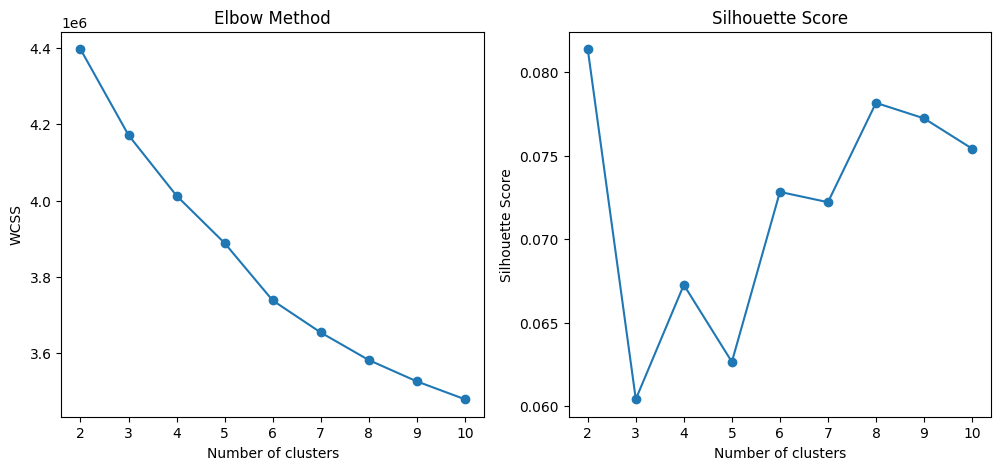

In [41]:
# wcss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), si, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

## 2 clusters

In [42]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(data_vec)

# split data_vec to 2 clusters
cluster0 = data_vec[kmeans.labels_ == 0]
cluster1 = data_vec[kmeans.labels_ == 1]

# Adding a column of ones for the intercept
cluster0_intercept = sm.add_constant(cluster0)
cluster1_intercept = sm.add_constant(cluster1)

cluster_vec = [cluster0_intercept, cluster1_intercept]

In [43]:
# according data label

cluster_label0 = data_label[np.where(kmeans.labels_ == 0)[0]]
cluster_label1 = data_label[np.where(kmeans.labels_ == 1)[0]]

In [44]:
# split the test set to 2 clusters
test0 = test_vec[np.where(kmeans.predict(test_vec) == 0)[0]]
test1 = test_vec[np.where(kmeans.predict(test_vec) == 1)[0]]

test0_intercept = sm.add_constant(test0)
test1_intercept = sm.add_constant(test1)

test0_label = np.sum(test0==0, axis=1)
test1_label = np.sum(test1==0, axis=1)

cluster_test = [test0_intercept, test1_intercept]
cluster_testlabel = [test0_label, test1_label]

### poisson thinning

In [45]:
cluster0_pois = poisson_thin(cluster_label0, eps)
cluster1_pois = poisson_thin(cluster_label1, eps)

cluster_pois = [cluster0_pois, cluster1_pois]

In [46]:
predict = []

for i in range(2):
    # i is the index of cluster
    model0 =  model_train(cluster_vec[i], cluster_pois[i][:,0])
    model1 =  model_train(cluster_vec[i], cluster_pois[i][:,1])

    pred0 = model0.predict(cluster_test[i])
    pred1 = model1.predict(cluster_test[i])
    pred = pred0 + pred1
    
    predict.append(pred)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                33877
Model:                            GLM   Df Residuals:                    33179
Model Family:        NegativeBinomial   Df Model:                          697
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4431e+05
Date:                Sun, 03 Mar 2024   Deviance:                       6992.1
Time:                        20:40:53   Pearson chi2:                 6.98e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5486
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3237      0.002   3238.652      0.0

In [47]:
predict

[array([668.10286985, 721.05147021, 701.60842567, ..., 684.61817581,
        620.55145546, 633.77041886]),
 array([617.94185188, 590.15264294, 666.80632557, ..., 606.11015853,
        605.62202167, 545.68540542])]

In [136]:
cluster_pois_mse0 = mean_squared_error(predict[0], cluster_testlabel[0])
cluster_pois_mse1 = mean_squared_error(predict[1], cluster_testlabel[1])

pois_mse = [cluster_pois_mse0, cluster_pois_mse1]

In [49]:
cluster_testlabel

[array([668, 720, 702, ..., 685, 620, 635]),
 array([619, 591, 664, ..., 606, 606, 544])]

In [50]:
print('test on poisson thinning model after clustering:')
pois_mse

test on poisson thinning model after clustering:


[0.6263819145848859, 1.350910899475938]

### binomial thinning

In [51]:
pop0 = [round(cluster_label0.shape[0], -1)]*cluster_label0.shape[0]
pop1 = [round(cluster_label1.shape[0], -1)]*cluster_label1.shape[0]
cluster_pop = [pop0, pop1]

cluster0_bin = binomthin(cluster_label0, eps, cluster_pop[0])
cluster1_bin = binomthin(cluster_label1, eps, cluster_pop[1])

cluster_bin = [cluster0_bin.reshape(2, -1), cluster1_bin.reshape(2,-1)]

In [87]:
cluster_bin[0]

array([[450, 470, 459, ..., 438, 439, 457],
       [214, 218, 183, ..., 176, 209, 184]])

In [53]:
predict_bin = []

for i in range(2):
    # i is the index of cluster
    model0 = model_train(cluster_vec[i], cluster_bin[i][0])
    model1 = model_train(cluster_vec[i], cluster_bin[i][1])

    pred0 = model0.predict(cluster_test[i])
    pred1 = model1.predict(cluster_test[i])

    pred = pred0 + pred1
    predict_bin.append(pred)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                33877
Model:                            GLM   Df Residuals:                    33179
Model Family:        NegativeBinomial   Df Model:                          697
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4428e+05
Date:                Sun, 03 Mar 2024   Deviance:                       6905.7
Time:                        20:47:54   Pearson chi2:                 6.90e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5498
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3250      0.002   3239.473      0.0

In [55]:
cluster_bin_mse0 = mean_squared_error(predict_bin[0], cluster_testlabel[0])
cluster_bin_mse1 = mean_squared_error(predict_bin[1], cluster_testlabel[1])

bin_mse = [cluster_bin_mse0, cluster_bin_mse1]

In [56]:
bin_mse

[0.6213469459876788, 1.3510078294901162]

## Multiclusters

### Poisson

In [68]:
def train_NB(X, y):
    """
    training model using Negative Binomial model
    """
    y_var = np.var(y)
    y_mean = np.mean(y)
    alpha = (y_var-y_mean)/(y_mean **2)
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=alpha))
    results = model.fit()
    
    return results

In [77]:
# cluster data into 3~10 clusters

res = {}

for i in range(3, 11):
    print('number of clusters: ', i)
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(data_vec)

    MSE = []
    for k in range(i):
        print(f'  cluster index {k}')
        # training set after clustering
        cluster_intercept = sm.add_constant(data_vec[kmeans.labels_ == k])
        label =  data_label[np.where(kmeans.labels_ == k)[0]]

        # test set after clustering
        test = sm.add_constant(test_vec[np.where(kmeans.predict(test_vec) == k)[0]])
        label_test = np.sum(test==0, axis=1)

        # poisson thinning label
        cluster_pois = poisson_thin(label, eps)
        
        # train model
        model0 = train_NB(cluster_intercept, cluster_pois[:,0])
        model1 = train_NB(cluster_intercept, cluster_pois[:,1])

        pred0 = model0.predict(test)
        pred1 = model1.predict(test)
        pred = pred0 + pred1

        mse = mean_squared_error(pred, label_test)
        MSE.append(mse)
        print('  error within cluster: ', mse)
       

    res[i] = MSE

number of clusters:  3
  cluster index 0
  error within cluster:  1.2980395875095012
  cluster index 1
  error within cluster:  0.5365990740106127
  cluster index 2
  error within cluster:  0.5385178317326025
number of clusters:  4
  cluster index 0
  error within cluster:  0.9502702895491107
  cluster index 1
  error within cluster:  1.5829888821674627
  cluster index 2
  error within cluster:  0.5379633576925792
  cluster index 3
  error within cluster:  0.5418346567863681
number of clusters:  5
  cluster index 0
  error within cluster:  0.92795821094525
  cluster index 1
  error within cluster:  1.6237670153481134
  cluster index 2
  error within cluster:  0.27300440122129604
  cluster index 3
  error within cluster:  0.6351378481223696
  cluster index 4
  error within cluster:  0.6677829933655289
number of clusters:  6
  cluster index 0
  error within cluster:  0.992201193954841
  cluster index 1
  error within cluster:  1.306588474802546
  cluster index 2
  error within cluster:  

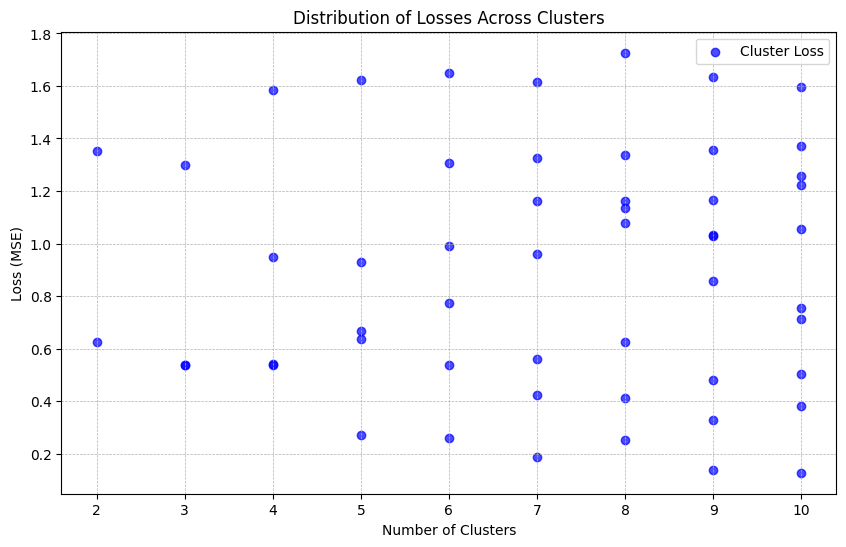

In [155]:
losses = []
cluster_sizes = []

for mse in pois_mse:
    losses.append(mse)
    cluster_sizes.append(2)

for k, v in res.items():
    losses.extend(v)  
    cluster_sizes.extend([k]*len(v))

plt.figure(figsize=(10, 6))
plt.scatter(cluster_sizes, losses, color='blue', alpha=0.7, label='Cluster Loss')
plt.title('Distribution of Losses Across Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss (MSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

### Binomial

In [104]:
res_bin = {}

for i in range(3, 11):
    print('number of clusters: ', i)
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(data_vec)

    MSE = []
    for k in range(i):
        print(f'  cluster index {k}')
        # training set after clustering
        cluster_intercept = sm.add_constant(data_vec[kmeans.labels_ == k])
        label =  data_label[np.where(kmeans.labels_ == k)[0]]

        # test set after clustering
        test = sm.add_constant(test_vec[np.where(kmeans.predict(test_vec) == k)[0]])
        label_test = np.sum(test==0, axis=1)

        # binomial thinning label
        pop = [round(label.shape[0], -1)]*label.shape[0]
        
        cluster_bin = binomthin(label, eps, pop)
        
        # train model
        model0 = train_NB(cluster_intercept, cluster_bin[0][0])
        model1 = train_NB(cluster_intercept, cluster_bin[0][1])

        pred0 = model0.predict(test)
        pred1 = model1.predict(test)
        pred = pred0 + pred1

        mse = mean_squared_error(pred, label_test)
        MSE.append(mse)
        print('  error within cluster: ', mse)
       

    res_bin[i] = MSE

number of clusters:  3
  cluster index 0
  error within cluster:  1.2954402980715587
  cluster index 1
  error within cluster:  0.5368606054593471
  cluster index 2
  error within cluster:  0.5268572856634074
number of clusters:  4
  cluster index 0
  error within cluster:  0.9472039691750379
  cluster index 1
  error within cluster:  1.5819235550599509
  cluster index 2
  error within cluster:  0.5289940817100625
  cluster index 3
  error within cluster:  0.538468087018399
number of clusters:  5
  cluster index 0
  error within cluster:  0.935494715357544
  cluster index 1
  error within cluster:  1.6227021828318429
  cluster index 2
  error within cluster:  0.2736737022658772
  cluster index 3
  error within cluster:  0.6600946938441927
  cluster index 4
  error within cluster:  0.6687482345258845
number of clusters:  6
  cluster index 0
  error within cluster:  0.9483993447600488
  cluster index 1
  error within cluster:  1.2999127797534995
  cluster index 2
  error within cluster: 

LinAlgError: SVD did not converge

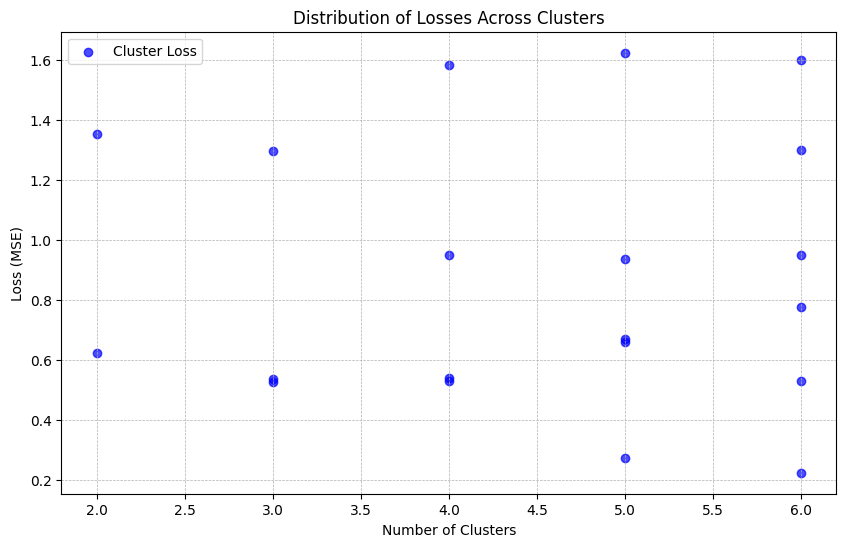

In [157]:
losses_bin = []
cluster_sizes_bin = []

for mse in bin_mse:
    losses_bin.append(mse)
    cluster_sizes_bin.append(2)

for k, v in res_bin.items():
    losses_bin.extend(v)  
    cluster_sizes_bin.extend([k]*len(v))

plt.figure(figsize=(10, 6))
plt.scatter(cluster_sizes_bin, losses_bin, color='blue', alpha=0.7, label='Cluster Loss')
plt.title('Distribution of Losses Across Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss (MSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

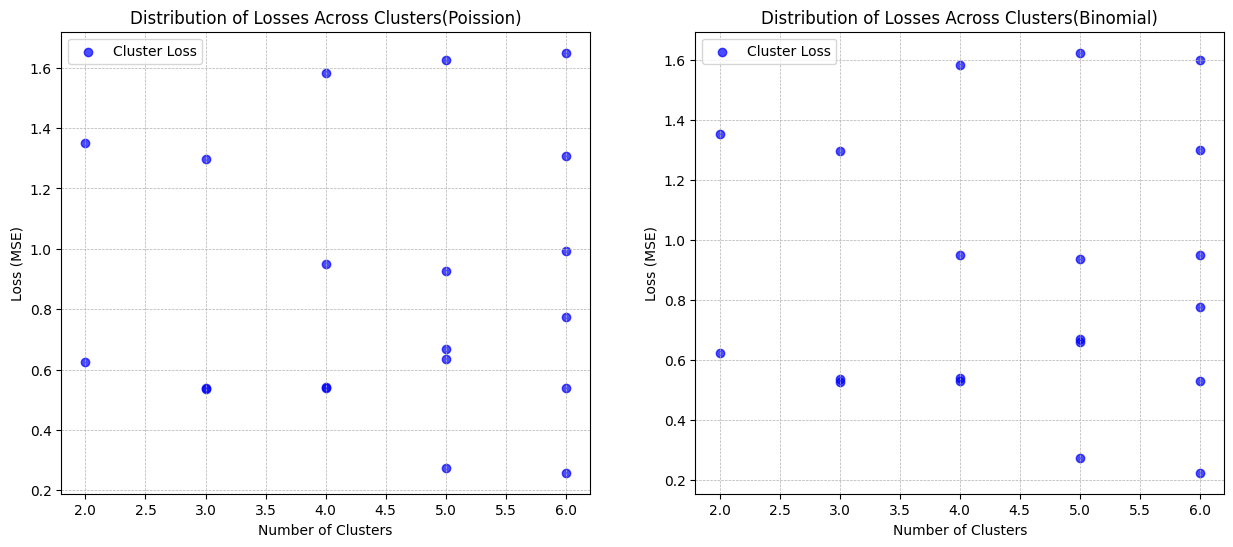

In [163]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.scatter(cluster_sizes[:20], losses[:20], color='blue', alpha=0.7, label='Cluster Loss')
plt.title('Distribution of Losses Across Clusters(Poission)')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss (MSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(1,2,2)

plt.scatter(cluster_sizes_bin, losses_bin, color='blue', alpha=0.7, label='Cluster Loss')
plt.title('Distribution of Losses Across Clusters(Binomial)')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss (MSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()